In [ ]:
import tensorflow as tf### models
import pandas as pd ### reading and processing data
import seaborn as sns ### visualization
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [ ]:
!nvidia-smi

Sat Apr  1 16:42:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
data = pd.read_csv("/content/sample_data/train_NIR5Yl1.csv")
data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          330045 non-null  int64  
 1   Tag         330045 non-null  object 
 2   Reputation  330045 non-null  float64
 3   Answers     330045 non-null  float64
 4   Username    330045 non-null  int64  
 5   Views       330045 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [ ]:
Le = LabelEncoder()
data['Tag'] = Le.fit_transform(data['Tag'])

In [ ]:
features = data[['Reputation', 'Answers', 'Views', 'Tag']]
target = data['Upvotes']

In [ ]:
features

,Reputation,Answers,Views,Tag
0,3942.0,2.0,7855.0,0
1,26046.0,12.0,55801.0,0
2,1358.0,4.0,8067.0,1
3,264.0,3.0,27064.0,0
4,4271.0,4.0,13986.0,1
...,...,...,...,...
330040,36.0,2.0,1063.0,1
330041,1649.0,2.0,23319.0,1
330042,6178.0,2.0,2453.0,1
330043,89.0,2.0,2107.0,4


In [ ]:
target

0           42.0
1         1175.0
2           60.0
3            9.0
4           83.0
           ...  
330040       0.0
330041      73.0
330042      15.0
330043       3.0
330044      37.0
Name: Upvotes, Length: 330045, dtype: float64

In [ ]:
data_preprocessed = pd.concat([features, target], axis=1)

In [ ]:
dataset = data_preprocessed

In [ ]:
dataset

,Reputation,Answers,Views,Tag,Upvotes
0,3942.0,2.0,7855.0,0,42.0
1,26046.0,12.0,55801.0,0,1175.0
2,1358.0,4.0,8067.0,1,60.0
3,264.0,3.0,27064.0,0,9.0
4,4271.0,4.0,13986.0,1,83.0
...,...,...,...,...,...
330040,36.0,2.0,1063.0,1,0.0
330041,1649.0,2.0,23319.0,1,73.0
330042,6178.0,2.0,2453.0,1,15.0
330043,89.0,2.0,2107.0,4,3.0


In [ ]:
tensor_data = tf.constant(dataset)
tensor_data = tf.cast(tensor_data, tf.float32)
# print(tensor_data)

In [ ]:
tensor_data = tf.random.shuffle(tensor_data)
# print(tensor_data[:5])

In [ ]:
X = tensor_data[:,0:-1]
print(X[:5])

tf.Tensor(
[[3.3921e+04 1.8000e+01 7.1868e+04 2.0000e+00]
 [1.0610e+03 1.0000e+00 1.6810e+03 5.0000e+00]
 [1.8500e+02 1.0000e+00 1.8060e+03 0.0000e+00]
 [4.1980e+03 4.0000e+00 1.3090e+03 3.0000e+00]
 [4.8840e+03 5.0000e+00 1.2191e+04 3.0000e+00]], shape=(5, 4), dtype=float32)


In [ ]:
y = tensor_data[:,-1]
print(y[:5].shape)
y = tf.expand_dims(y, axis = -1)
print(y[:5])

(5,)
tf.Tensor(
[[2795.]
 [  17.]
 [  23.]
 [  11.]
 [  78.]], shape=(5, 1), dtype=float32)


In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [ ]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)

(264036, 4)
(264036, 1)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(128,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

(33004, 4)
(33004, 1)


In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(128,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)

(33005, 4)
(33005, 1)


In [ ]:
# do not need 
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 0.9744355 ,  3.9430382 ,  0.525532  , -0.6189888 ],
       [-0.2485274 , -0.81647563, -0.34795123,  0.58507645],
       [-0.2811298 , -0.81647563, -0.3463956 , -1.421699  ],
       [-0.13177648,  0.0234386 , -0.35258082, -0.21763371],
       [-0.10624537,  0.30341   , -0.21715339, -0.21763371]],
      dtype=float32)>

In [ ]:
early_stopping = EarlyStopping(patience = 8)
checkpoint = ModelCheckpoint("best_model.h5" , save_best_only = True, save_weights_only = True)
lr_scheduler = ReduceLROnPlateau(patience = 4, factor = 0.3)

callbacks = [early_stopping, checkpoint, lr_scheduler]

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()

In [ ]:
model = tf.keras.Sequential([
                             InputLayer(input_shape = (4,)),
                             normalizer,
                             Dense(128, activation = "relu"),
                             Dense(128, activation = "relu"),
                             Dense(128, activation = "relu"),
                             Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,802
Trainable params: 33,793
Non-trainable params: 9
____________________________________________________

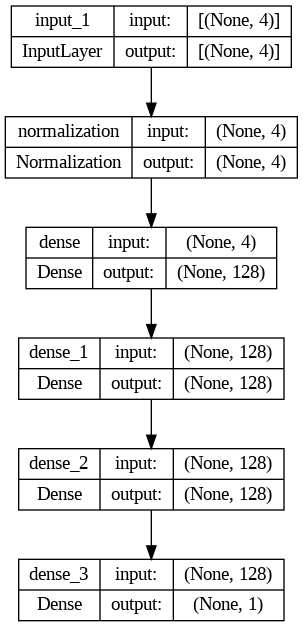

In [ ]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

In [ ]:
# pretrained_model = model which is already trained - (transfer learning)
#  a. keep less learning rate
optimizer = Adam(learning_rate=0.0004) 
model.compile(loss = tf.keras.losses.MSE, optimizer = optimizer, metrics = [rmse])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 100,callbacks = callbacks,verbose = 1)

Epoch 1/100
2062/2062 [==============================] - 11s 4ms/step - loss: 10340361.0000 - root_mean_squared_error: 3215.6433 - val_loss: 11537191.0000 - val_root_mean_squared_error: 3396.6440 - lr: 4.0000e-04
Epoch 2/100
2062/2062 [==============================] - 7s 3ms/step - loss: 8904003.0000 - root_mean_squared_error: 2983.9575 - val_loss: 10782125.0000 - val_root_mean_squared_error: 3283.6145 - lr: 4.0000e-04
Epoch 3/100
2062/2062 [==============================] - 7s 4ms/step - loss: 8463173.0000 - root_mean_squared_error: 2909.1533 - val_loss: 10113271.0000 - val_root_mean_squared_error: 3180.1370 - lr: 4.0000e-04
Epoch 4/100
2062/2062 [==============================] - 8s 4ms/step - loss: 7977762.0000 - root_mean_squared_error: 2824.4932 - val_loss: 9333844.0000 - val_root_mean_squared_error: 3055.1340 - lr: 4.0000e-04
Epoch 5/100
2062/2062 [==============================] - 7s 4ms/step - loss: 7401134.0000 - root_mean_squared_error: 2720.5024 - val_loss: 8432304.0000 - v

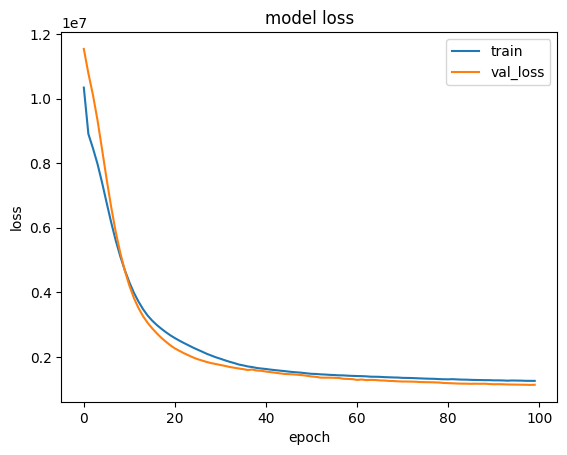

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

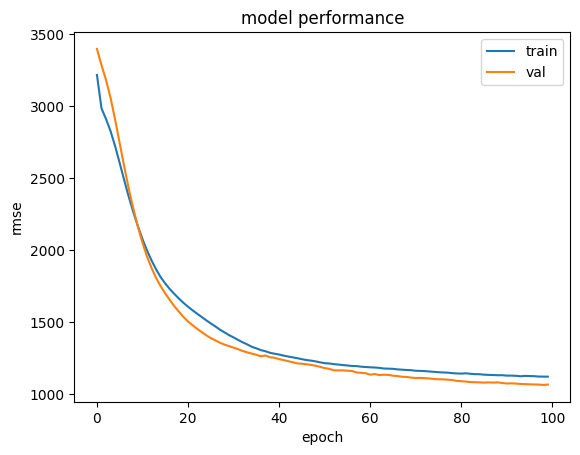

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()